Cerco di capire sta cosa dei J che vengono imparati subito ma con slope sbagliata, e poi si aggiustano

In [1]:
import sys
sys.path.append('..')
import selex_dca, utils

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from utils import one_hot
import selex_dca
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

from adabmDCA.utils import init_parameters, init_chains, get_device, get_dtype, get_mask_save
from adabmDCA.sampling import get_sampler
from adabmDCA.training import train_graph

from IPython.display import display, Latex

/home/scrotti/Aptamer2025py/experiments/../selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
experiment_id = "Dop8V030"
round_ids = ["ARN", "R01", "R02N"]

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
dtype = torch.float32

In [ ]:
sequences = utils.sequences_from_files(experiment_id, round_ids)

Extracting sequences...


In [ ]:
sequences_oh = [one_hot(seq).to(dtype=dtype) for seq in sequences]

In [ ]:
from importlib import reload
reload(callback)
reload(energy_models)

In [ ]:
total_reads = torch.Tensor([s.shape[0] for s in sequences_oh])

In [ ]:
tr = tree.Tree()
tr.add_node(-1, name = "R01")
tr.add_node(0, name = "R02N")

selected_modes = torch.BoolTensor(
    [[1], [1]]
)

In [ ]:
L, q = sequences_oh[0][0].shape

k = torch.randn(L, q, dtype=dtype) * 1e-4
h = torch.randn(L, q, dtype=dtype) * 1e-4
J = utils.rand_coupling_matrix(L, q, dtype=dtype) * 1e-4

Ns0 = energy_models.IndepSites(k)
potts = energy_models.Potts(J, h)

ps = selex_distribution.MultiModeDistribution(potts, normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes).to(device)

In [ ]:
batch_size = 10**6
data_loaders = [data_loading.SelexRoundDataLoader(seq_oh, batch_size=batch_size, device=device) for seq_oh in sequences_oh]
n_rounds = len(data_loaders) 

In [ ]:
n_chains = 10**5
chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype, device=device)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype, device=device)

In [ ]:
callbacks = [callback.ConvergenceMetricsCallback(), callback.PearsonCovarianceCallback()]

In [ ]:
n_sweeps = 10
lr = 0.01
target_pearson = 1
max_epochs = 1000

training.train(model, data_loaders, total_reads, chains, n_sweeps, max_epochs, target_pearson, 
               lr=lr, callbacks=callbacks, log_weights=log_weights)

 0.00%[                                                                                                       …

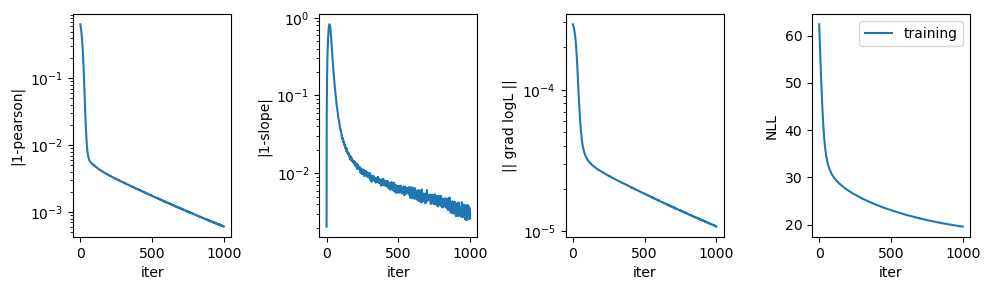

In [162]:
callbacks[0].plot();

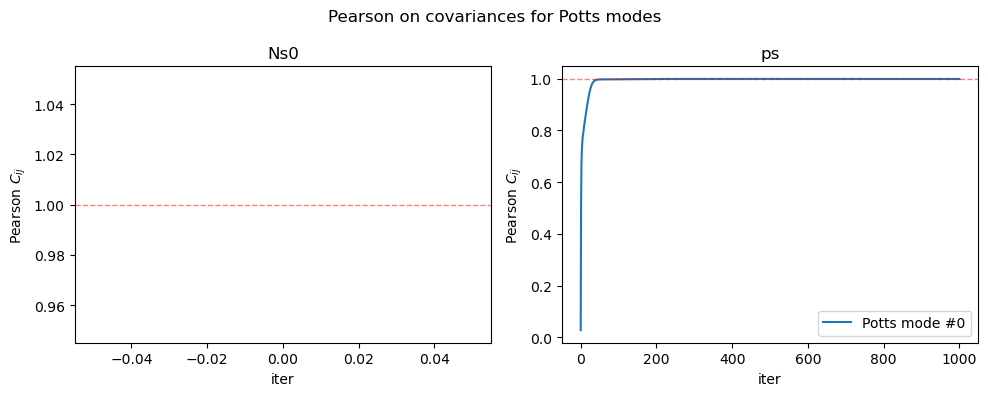

In [163]:
callbacks[1].plot();

<IPython.core.display.Latex object>

Multi-round


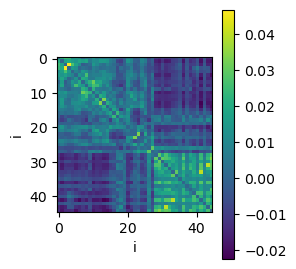

In [164]:
potts_zerosum = potts.set_zerosum_gauge()
J = potts_zerosum.J.detach().cpu()
h = potts_zerosum.h.detach().cpu()

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(J)
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
plt.colorbar(im)
plt.tight_layout()
display(Latex("$F_{ij}=\\sqrt {\\sum_{ab}(J_{ij}^{ab})^2}$"))
print('Multi-round')

## Try to simply apply DCA to the last round

In [56]:
from importlib import reload
reload(utils)
reload(energy_models)
reload(selex_distribution)
reload(callback)

<module 'callback' from '/home/scrotti/Aptamer2025py/experiments/../callback.py'>

In [ ]:
fi_last, fij_last, _ = utils.frequences_from_sequences_oh(sequences_oh[-1])

In [120]:
# k_last = torch.randn(L, q, dtype=dtype) * 1e-4
# K_last = utils.rand_coupling_matrix(L, q, dtype=dtype) * 1e-4
# k_last = torch.zeros(L, q, dtype=dtype)
# K_last = torch.zeros(L, q, L, q, dtype=dtype)

k_last = torch.log(fi_last)
K_last = torch.zeros(L, q, L, q, dtype=dtype)

Ns0_last = energy_models.Potts(K_last, k_last)
model_last = selex_distribution.MultiRoundDistribution(Ns0_last).to(device)

In [121]:
batch_size = 10**6
data_loaders_last = [data_loading.SelexRoundDataLoader(seq_oh, batch_size=batch_size, device=device) for seq_oh in [sequences_oh[-1]]]

n_rounds_last = len(data_loaders_last) 
n_chains = 10**5
chains_last = training.init_chains(n_rounds_last, n_chains, L, q, dtype=dtype, device=device)
log_weights_last = torch.zeros(n_rounds_last, n_chains, dtype=dtype, device=device)

total_reads_last = torch.tensor([total_reads[-1]])

callbacks_last = [callback.ConvergenceMetricsCallback(), callback.PearsonCovarianceCallback()]

In [143]:
n_sweeps = 10
lr = 0.01
max_epochs = 1000

training.train(model_last, data_loaders_last, total_reads_last, chains_last, n_sweeps, max_epochs,
               lr=lr, callbacks=callbacks_last, log_weights=log_weights_last)

 0.00%[                                                                                                       …

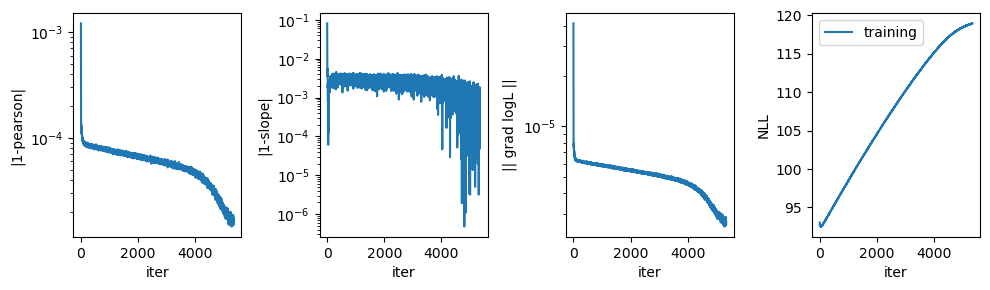

In [165]:
callbacks_last[0].plot();

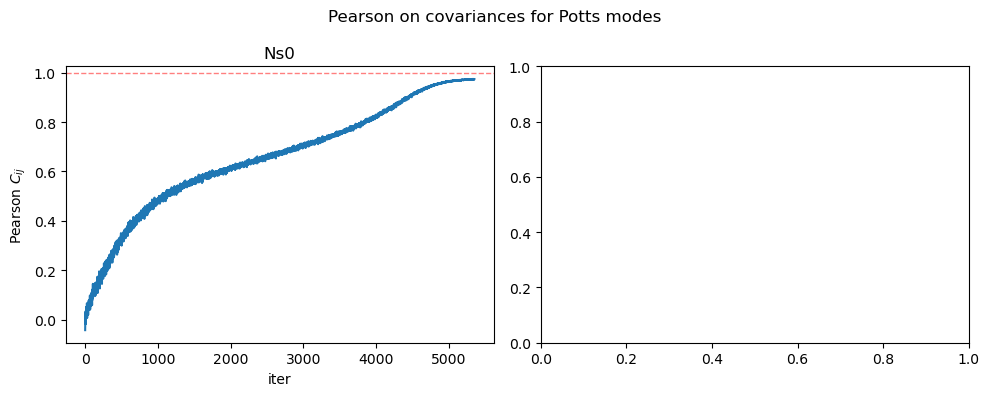

In [166]:
callbacks_last[1].plot();

<IPython.core.display.Latex object>

Last round


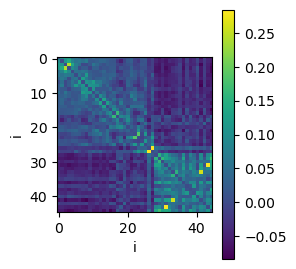

In [167]:
from IPython.display import display, Latex

potts_zerosum = Ns0_last.set_zerosum_gauge()
J_last = potts_zerosum.J.detach().cpu()
h_last = potts_zerosum.h.detach().cpu()

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(J_last)
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
plt.colorbar(im)
plt.tight_layout()
display(Latex("$F_{ij}=\\sqrt {\\sum_{ab}(J_{ij}^{ab})^2}$"))
print('Last round')

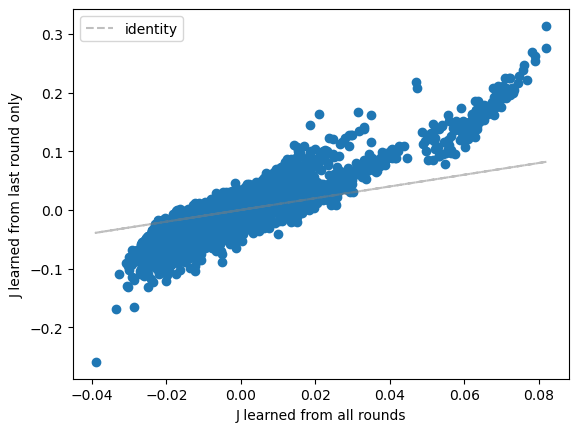

In [168]:
plt.scatter(utils.off_diagonal_terms(J), utils.off_diagonal_terms(J_last))
plt.xlabel('J learned from all rounds')
plt.ylabel('J learned from last round only')
plt.plot(utils.off_diagonal_terms(J), utils.off_diagonal_terms(J), ls='--', color='gray', alpha=0.5, label='identity')
utils.compute_pearson(utils.off_diagonal_terms(J), utils.off_diagonal_terms(J_last))
plt.legend();

0.5571125745773315

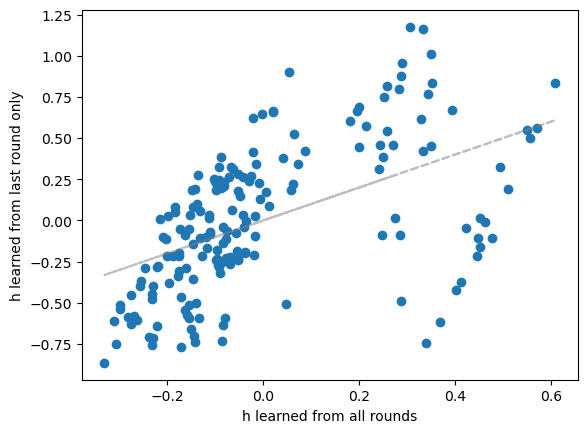

In [169]:
plt.scatter(h, h_last)
plt.xlabel('h learned from all rounds')
plt.ylabel('h learned from last round only')
plt.plot(h.reshape(-1), h.reshape(-1), ls='--', color='gray', alpha=0.5)
torch.corrcoef(torch.stack((h.reshape(-1), h_last.reshape(-1))))[0,1].item()

## Compare logps

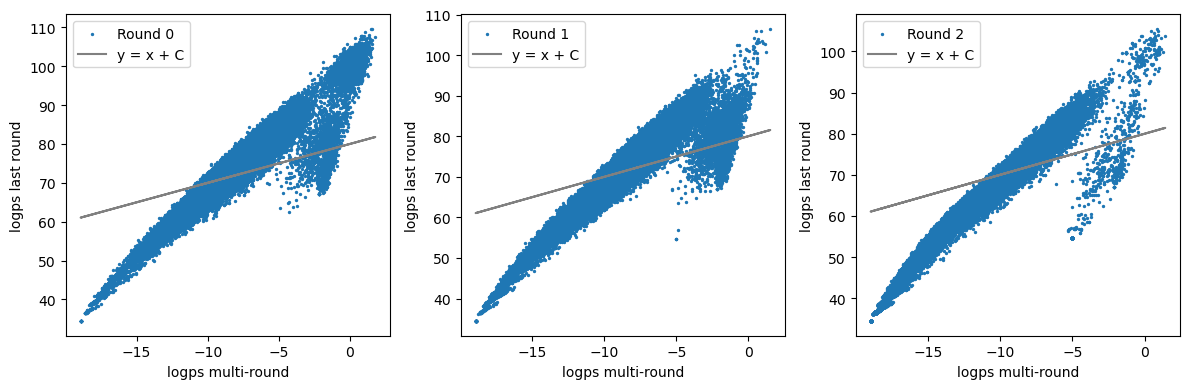

In [161]:
fig, axes = plt.subplots(1, n_rounds, figsize=(12,4))
N = 10**5

with torch.no_grad():
    for t in range(n_rounds):
        X = sequences_oh[t].to(device)
        logps = model.selection_energy_at_round(X, 1).detach().cpu()
        logps_last = model_last.round_zero.compute_energy(X).detach().cpu()
        ax = axes[t]
        # idx = torch.multinomial(torch.ones(len(X)), N)
        idx = random.sample(range(len(X)), N)
        ax.scatter(logps[idx], logps_last[idx], label=f'Round {t}', s=2)
        ax.plot(logps[idx], logps[idx] + 80, color='gray', label='y = x + C')
        ax.legend()
        ax.set_xlabel('logps multi-round'); ax.set_ylabel('logps last round')
fig.tight_layout()